# Final project AH2179: Public transport arrival delay prediction

Jiani She, jianis@kth.se <br>
Thomas Bartholomeus Koning, tbkoning@kth.se


## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import datetime as dt
from scipy.stats import shapiro
from scipy.stats import kstest
from statsmodels.graphics.gofplots import qqplot

## Import data

In [2]:
df = pd.read_csv('Dataset-PT.csv', header = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 31 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Calendar_date                      545103 non-null  int64  
 1   route_id                           545103 non-null  int64  
 2   bus_id                             545103 non-null  int64  
 3   stop_sequence                      545103 non-null  int64  
 4   arrival_delay                      545103 non-null  int64  
 5   dwell_time                         545103 non-null  int64  
 6   travel_time_for_previous_section   545103 non-null  int64  
 7   scheduled_travel_time              545103 non-null  int64  
 8   upstream_stop_delay                545103 non-null  int64  
 9   origin_delay                       545103 non-null  int64  
 10  previous_bus_delay                 545103 non-null  int64  
 11  previous_trip_travel_time          5451

The dataset is imported. The header parameter is set to 1, because the second line of the .csv file contains the titles. The results of the .info() line shows that the dataset consists of 31 columns and 545103 lines. None of the lines contains empty cells. Most columns in the dataset contains integers. The traffic condition and recurrent delay are continous values. Lastly, the weather, temperature, day of the week and time of the day columns consist of categorical data.

The column to be predicted is the arrival_delay at each stop.

## Step 1: Data pre-processing

This step is all about discovering the dataset and preparing this dataset for the analysis in the next steps. We will first execute a descriptive analysis in step 1.1 to discover what the dataset looks like and to find patterns in the dataset. After this step, we continue with preparing the data for the rest of the analysis based on the finding of the descriptive analysis (step 1.2). Afterwards we will create some extra features in the feature engineering step (step 1.3). Lastly, we finish this section with step 1.4, an exploratory data analysis on the final data set that we will use from step 2 onwards.  

### Step 1.1: Descriptive data analysis

In the next cells we will first look at the first 10 rows of the dataset to get a general picture of what the dataset looks like:

In [3]:
df.head(10)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,0,1,0,1,0,0,1
5,20220108,4,41344,6,260,13,105,38,242,100,...,0,0,0,0,1,0,1,0,0,1
6,20220108,4,41344,7,278,12,43,79,260,100,...,0,0,0,0,1,0,1,0,0,1
7,20220108,4,41344,8,272,8,85,97,278,100,...,0,0,0,0,1,0,1,0,0,1
8,20220108,4,41344,9,292,24,83,47,272,100,...,0,0,0,0,1,0,1,0,0,1
9,20220108,4,41344,10,351,9,43,85,292,100,...,0,0,0,0,1,0,1,0,0,1


At the beginning we have seen with df.info() statement that the calendar date is an integer value. The previous cell shows that the calendar is formatted as YearMonthDay. To be able to make some plots over time in this step, it is useful to have the date in a datetime format. We do this in the next cell. We create a new column with the date in an improved format. With the df.head() statement and df.info() we show that the new column indeed contains the right data format.

In [4]:
df["date"] = pd.to_datetime(df["Calendar_date"], format='%Y%m%d')
df.head(10)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,date
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
5,20220108,4,41344,6,260,13,105,38,242,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
6,20220108,4,41344,7,278,12,43,79,260,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
7,20220108,4,41344,8,272,8,85,97,278,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
8,20220108,4,41344,9,292,24,83,47,272,100,...,0,0,0,1,0,1,0,0,1,2022-01-08
9,20220108,4,41344,10,351,9,43,85,292,100,...,0,0,0,1,0,1,0,0,1,2022-01-08


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 32 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Calendar_date                      545103 non-null  int64         
 1   route_id                           545103 non-null  int64         
 2   bus_id                             545103 non-null  int64         
 3   stop_sequence                      545103 non-null  int64         
 4   arrival_delay                      545103 non-null  int64         
 5   dwell_time                         545103 non-null  int64         
 6   travel_time_for_previous_section   545103 non-null  int64         
 7   scheduled_travel_time              545103 non-null  int64         
 8   upstream_stop_delay                545103 non-null  int64         
 9   origin_delay                       545103 non-null  int64         
 10  previous_bus_delay  

The results shows that we get the date in the right format and with the right datatype (datetime64)

Next up we want to have a better look at the object columns in the dataset (weather, temperature, day_of_week, time_of_day). First we will look at which unique values are in these columns:

In [6]:
print("Objects in weather column: ", df["weather"].unique())
print("Objects in temperature column: ", df["temperature"].unique())
print("Objects in day_of_week column: ", df["day_of_week"].unique())
print("Objects in time_of_day column: ", df["time_of_day"].unique())

Objects in weather column:  ['Light Snow' 'Normal' 'Light Rain' 'Rain' 'Snow']
Objects in temperature column:  ['Normal' 'Cold' 'Extra cold']
Objects in day_of_week column:  ['weekend' 'weekday']
Objects in time_of_day column:  ['OP' 'MP' 'AP']


The found elements in the object columns correspond to the last 13 columns of the dataset. Based on this, we can conclude that one-hot encoding was applied to the 4 object columns.

The next step is to get more insights in the data in each column. In the first following cell we will find basic summary statistics of each column in DataFrame. For the sake of readibility of the results, df.descirbe() function is split up in two cells. The cells afterwards, we will zoom in on specific columns:

In [7]:

df[["route_id", "bus_id", "stop_sequence", "arrival_delay", "dwell_time", 
             "travel_time_for_previous_section", "scheduled_travel_time", "upstream_stop_delay", 
             "origin_delay", "previous_bus_delay", "previous_trip_travel_time", "traffic_condition",
             "recurrent_delay"]].describe()

,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,previous_bus_delay,previous_trip_travel_time,traffic_condition,recurrent_delay
count,545103.0,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000
mean,4.0,42960.801278,14.000000,134.972238,31.994665,71.440968,105.918404,135.651912,75.107237,134.379284,73.183840,73.154933,72.750008
std,0.0,1707.986641,7.788888,193.899487,27.215700,37.590646,36.420995,190.271573,133.625958,193.635484,35.678285,32.321151,29.590991
min,4.0,41343.000000,1.000000,-3493.000000,0.000000,0.000000,38.000000,-3403.000000,-3061.000000,-3493.000000,-2.000000,18.333333,27.750000
25%,4.0,41364.000000,7.000000,11.000000,17.000000,45.000000,75.000000,14.000000,15.000000,11.000000,46.000000,47.666667,48.627737
50%,4.0,41731.000000,14.000000,88.000000,25.000000,64.000000,104.000000,86.000000,27.000000,88.000000,64.000000,65.000000,64.614679
75%,4.0,44413.000000,21.000000,209.000000,41.000000,93.000000,129.000000,206.000000,68.000000,208.000000,93.000000,93.000000,91.542857
max,4.0,45808.000000,27.000000,2257.000000,1616.000000,1069.000000,198.000000,2257.000000,1812.000000,2230.000000,1069.000000,732.666667,211.916667


In the results above we see that the dataset only contains data on busses with route_ID 4. The dataset has data on several bus_id numbers. So we have data on multiple busses driving on the same line. Furthermore we see that the arrival_delay ranges between -3493 seconds and 2257 seconds. This means that there was a bus that arrived approximately 58 minutes early, but also that there was a bus that arrived nearly 38 minutes late. On average thne busses arrived less than 2 minutes late. For the dwell time we have an average of 32 seconds and an upper quartile of 41 seconds. However, the longest dwell time was nearly 27 minutes. For both the travel time on the previous section (stop-2, stop-1) and the scheduled travel time (stop-1, stop), we see that both have nearly the same standard deviation. We see that for the minimum, lower quartile, average and upper quartile, the scheduled_travel_time is approxiamtely 30 to 40 seconds higher than the travel_time_for previous_section. The same holds for the upstream_stop_delay and the previous_bus_delay. Both are very similar. When we compare the origin_delay with the upstream_stop_delay, we see that the latter is higher, meaning that on average the delay extends during a trip.For the previous_trip_travel_time, traffic_condition and recurrent_delay we see high similarities in the summary statics aswell.

In [8]:
df[["factor(weather)Light_Rain", "factor(weather)Light_Snow", "factor(weather)Normal",
   "factor(weather)Rain", "factor(weather)Snow", "factor(temperature)Cold",
   "factor(temperature)Extra_cold", "factor(temperature)Normal", "factor(day_of_week)weekday",
   "factor(day_of_week)weekend", "factor(time_of_day)Afternoon_peak", "factor(time_of_day)Morning_peak",
   "factor(time_of_day)Off-peak"]].describe()

,factor(weather)Light_Rain,factor(weather)Light_Snow,factor(weather)Normal,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
count,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000
mean,0.024469,0.017831,0.944722,0.006191,0.006786,0.112735,0.017931,0.869335,0.767101,0.232899,0.208678,0.164892,0.626430
std,0.154499,0.132339,0.228522,0.078442,0.082097,0.316268,0.132699,0.337034,0.422679,0.422679,0.406364,0.371083,0.483752
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


When we consider the one-hot encoded columns (based on the object columns) we see that the dataset is imbalanced in the occurence of some of the objects. For example, there is much more normal whether than there is (light) rain or (light) snow. Later on in this section we plot this to visually show these results.

In the next cell we zoom in on the Calendar_date column. We will look at the distribution of the number of measurements over the day. First we create a plot for the full dataset. For this we use the value_counts function for each unique value (dates) in the date column in the dataset. Afterwards we split the data for each month. Based on this, we create similar plots for each month seperately. In these last plots we distinguish between weekdays and weekend. In this way we can explore whether the amount of datapoints are different in the weekends.

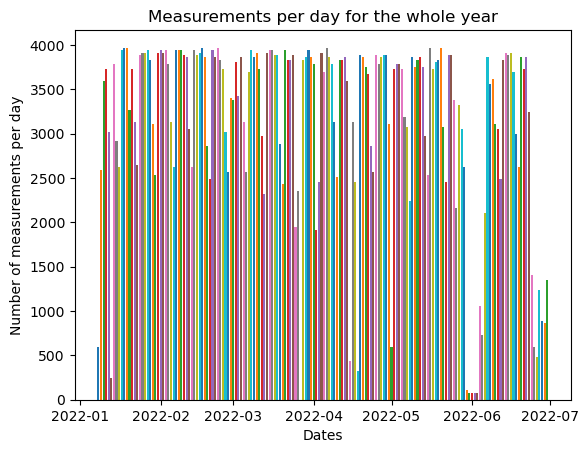

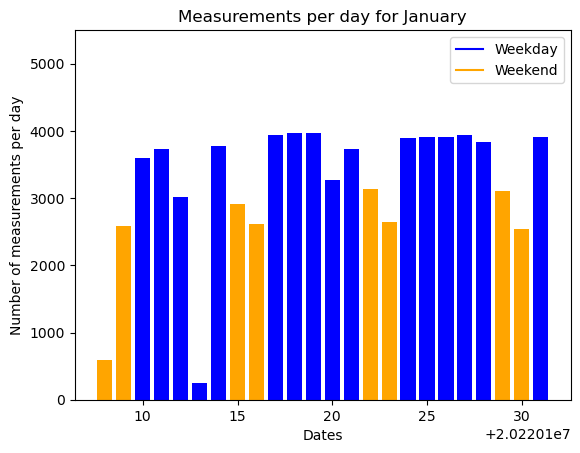

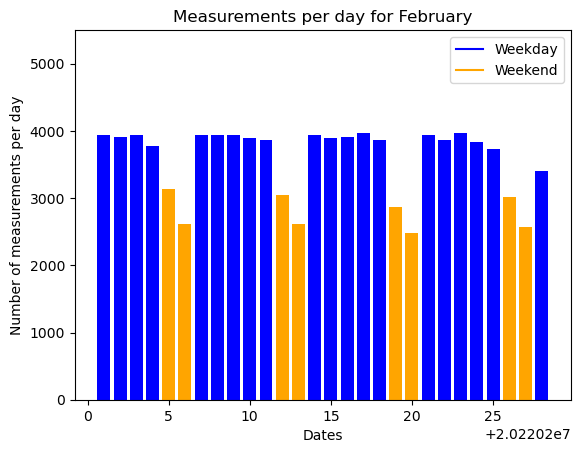

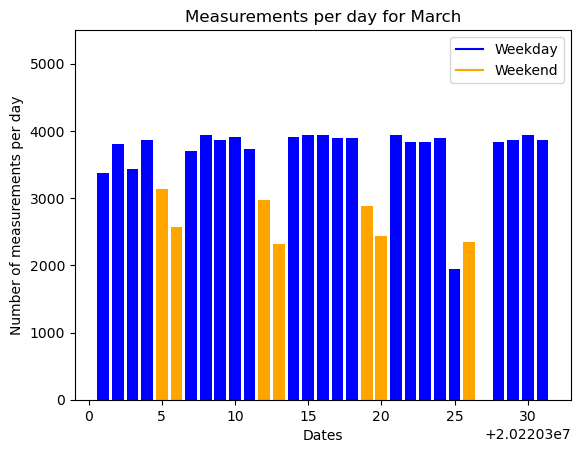

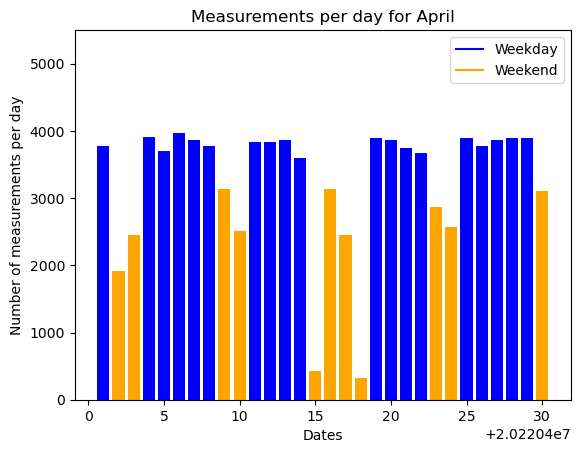

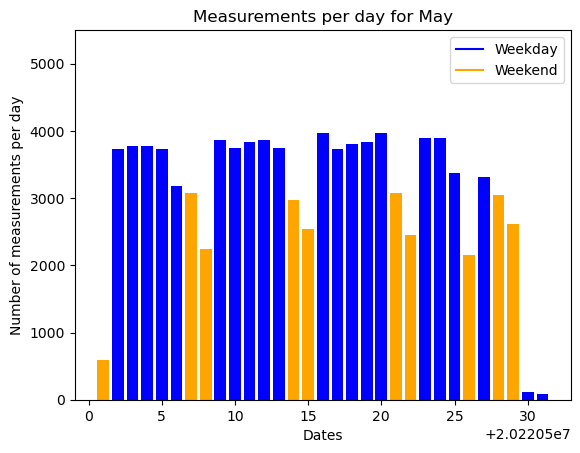

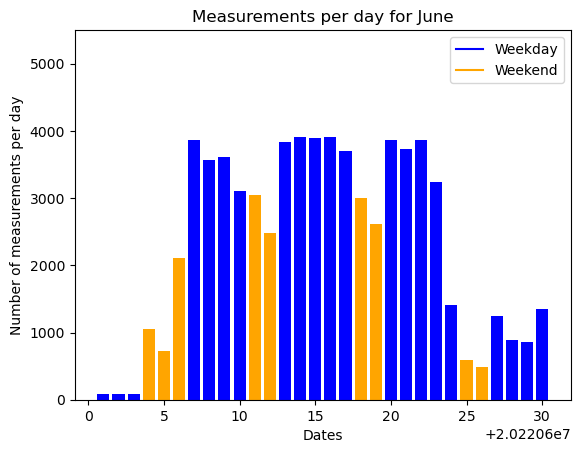

In [9]:
# Plot the number of data points per day!
for i in df["date"].unique():
    count = df["date"].value_counts()[i]
    plt.bar(i, count)
    plt.xlabel("Dates")
    plt.ylabel("Number of measurements per day")
    plt.title("Measurements per day for for the full half a year")
plt.show()


# Plot the number of data points per day for each month seperately:
df['month'] = df['date'].dt.month
for i in df["month"].unique():
    df_month = df.loc[df['month'] == i]
    #df_month.query("Calendar_date==20220108")["day_of_week"]
    for j in df_month["Calendar_date"].unique():
        week_day_list = df_month.loc[df["Calendar_date"] == j, "day_of_week"]
        week_day = week_day_list[week_day_list.index[0]]
        count = df_month["Calendar_date"].value_counts()[j]
        color_list = ['blue' if (week_day == "weekday") else 'orange']
        plt.bar(j, count, color=color_list)
        plt.ylim(0,5500)
        plt.xlabel("Dates")
        plt.ylabel("Number of measurements per day") 
        
        #Reference for creating the legend: https://stackoverflow.com/questions/11983024/matplotlib-legends-not-working
        blue_bar = mlines.Line2D([], [], color='blue', label='Weekday')
        orange_bar = mlines.Line2D([], [], color='orange', label='Weekend')
        plt.legend(handles=[blue_bar, orange_bar])

        if i == 1:
            plt.title("Measurements per day for January")
        elif i == 2:
            plt.title("Measurements per day for February")
        elif i == 3:
            plt.title("Measurements per day for March")
        elif i == 4:
            plt.title("Measurements per day for April")
        elif i == 5:
            plt.title("Measurements per day for May")
        elif i == 6:
            plt.title("Measurements per day for June")
        else:
            print("Warning: Plot created for undefined month!")    
    plt.show()


When considering the plots created in the previous cell, we clearly see that some days have less data than others. Generally speaking, weekend days have less data than week days, with sunday even less than saturdays.

Next up we visually present the object columns in the dataset, to show the imbalance that we found earlier on this section.

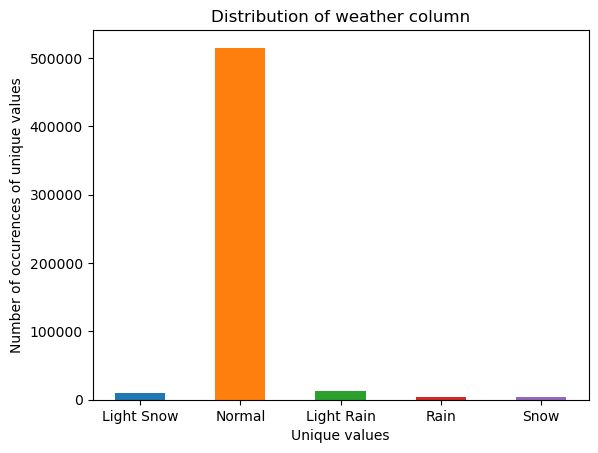

In [10]:
# Distribution of the wheather column:
for i in df["weather"].unique():
    count = df["weather"].value_counts()[i]
    plt.bar(i, count, width = 0.5)
    plt.xlabel("Unique values")
    plt.ylabel("Number of occurences of unique values")
    plt.title("Distribution of weather column")
plt.show()

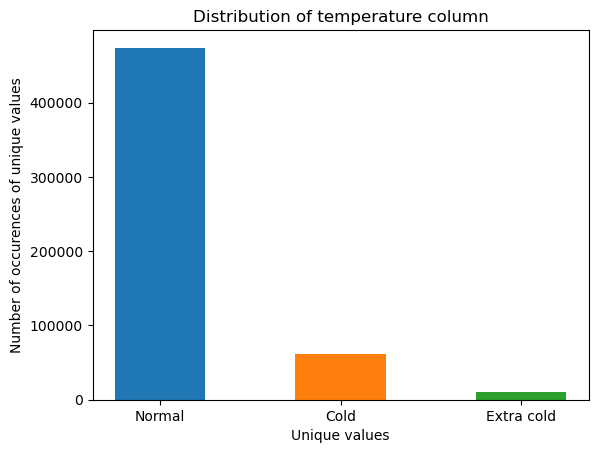

In [11]:
# Distribution of the temperature column:
for i in df["temperature"].unique():
    count = df["temperature"].value_counts()[i]
    plt.bar(i, count, width = 0.5)
    plt.xlabel("Unique values")
    plt.ylabel("Number of occurences of unique values")
    plt.title("Distribution of temperature column")
plt.show()

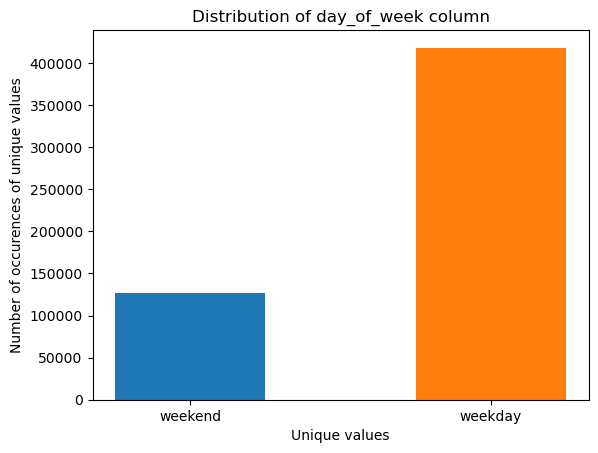

In [12]:
# Distribution of the day_of_week column:
for i in df["day_of_week"].unique():
    count = df["day_of_week"].value_counts()[i]
    plt.bar(i, count, width = 0.5)
    plt.xlabel("Unique values")
    plt.ylabel("Number of occurences of unique values")
    plt.title("Distribution of day_of_week column")
plt.show()

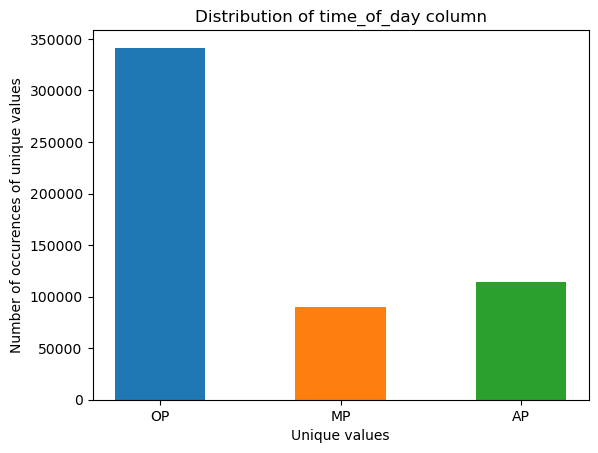

In [13]:
# Distribution of the time_of_day column:
for i in df["time_of_day"].unique():
    count = df["time_of_day"].value_counts()[i]
    plt.bar(i, count, width = 0.5)
    plt.xlabel("Unique values")
    plt.ylabel("Number of occurences of unique values")
    plt.title("Distribution of time_of_day column")
plt.show()

The last for 4 plots clearly show that the data is not evenly distributed in the 4 object columns in the data set. We see in the weather column for example that there are much more days with normal weather, than that there rainy or snowy days. We see the same pattern in the temperature column, which contains much more often normal as value than cold or extra cold. In the weekday bar chart we see a pattern that was to be expected, approximately 3 times as many weekdays as there are weekenddays in the dataset. Lastly for the time of day column we have much more OP (off-peak) values than that we have MP (morning peak) or AF (afternoon peak) values.
In conclusion, the object columns, and therefore also the one-hot encoding columns made based on these columns, are fairly imbalanced. 

It is also important to consider the relationship between the columns in the data set, for example with a correlation matrix and a heatmap of the correlation matrix.

In [14]:
df_correlation = df.drop(["Calendar_date", "route_id", "bus_id", "stop_sequence", "weather", "temperature", 
                          "day_of_week","time_of_day"], axis=1)
df_correlation.corr()

C:\Users\tomko\AppData\Local\Temp\ipykernel_28172\2434081628.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_correlation.corr()


,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,previous_bus_delay,previous_trip_travel_time,traffic_condition,recurrent_delay,...,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,month
arrival_delay,1.000000,0.089433,0.081113,-0.142228,0.975019,0.716324,0.265434,-0.036870,-0.043104,-0.069122,...,-0.001579,-0.013595,-0.024602,0.022444,-0.190783,0.190783,-0.091946,-0.079354,0.138109,0.128526
dwell_time,0.089433,1.000000,0.314884,-0.091127,-0.064040,-0.007937,-0.017797,-0.013858,-0.016354,-0.020866,...,0.002198,-0.025249,-0.022725,0.032641,0.074188,-0.074188,0.050924,0.015988,-0.055041,0.018524
travel_time_for_previous_section,0.081113,0.314884,1.000000,-0.262382,0.030967,0.012168,0.047280,-0.243823,-0.269617,-0.293594,...,0.002113,0.006813,-0.007542,-0.003423,0.073016,-0.073016,0.046240,0.038868,-0.068658,0.011965
scheduled_travel_time,-0.142228,-0.091127,-0.262382,1.000000,-0.056838,0.005330,-0.136826,0.617814,0.681883,0.727653,...,0.002066,-0.017197,-0.025146,0.026038,0.165351,-0.165351,0.129195,0.054297,-0.150178,0.017381
upstream_stop_delay,0.975019,-0.064040,0.030967,-0.056838,1.000000,0.729940,0.250198,-0.055600,-0.062058,-0.084258,...,-0.001929,-0.014920,-0.025108,0.023887,-0.188221,0.188221,-0.085657,-0.080449,0.133667,0.129430
origin_delay,0.716324,-0.007937,0.012168,0.005330,0.729940,1.000000,0.169857,0.012691,0.014888,-0.001412,...,-0.006193,-0.049544,-0.039400,0.062004,-0.140618,0.140618,0.000716,-0.107589,0.081929,0.148145
previous_bus_delay,0.265434,-0.017797,0.047280,-0.136826,0.250198,0.169857,1.000000,0.022439,-0.019429,-0.066933,...,-0.000504,-0.013715,-0.022832,0.021860,-0.189343,0.189343,-0.088458,-0.079253,0.135101,0.126982
previous_trip_travel_time,-0.036870,-0.013858,-0.243823,0.617814,-0.055600,0.012691,0.022439,1.000000,0.904514,0.832534,...,0.002627,0.006155,-0.007665,-0.002758,0.078855,-0.078855,0.053918,0.033343,-0.070869,0.011450
traffic_condition,-0.043104,-0.016354,-0.269617,0.681883,-0.062058,0.014888,-0.019429,0.904514,1.000000,0.917853,...,0.003911,0.005919,-0.008552,-0.002188,0.087818,-0.087818,0.062773,0.030604,-0.076207,0.012320
recurrent_delay,-0.069122,-0.020866,-0.293594,0.727653,-0.084258,-0.001412,-0.066933,0.832534,0.917853,1.000000,...,0.000820,-0.002599,-0.011106,0.006812,0.085398,-0.085398,0.059799,0.039054,-0.080191,-0.003878


C:\Users\tomko\AppData\Local\Temp\ipykernel_28172\2447549615.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_correlation.corr(), annot=False)


<Axes: >

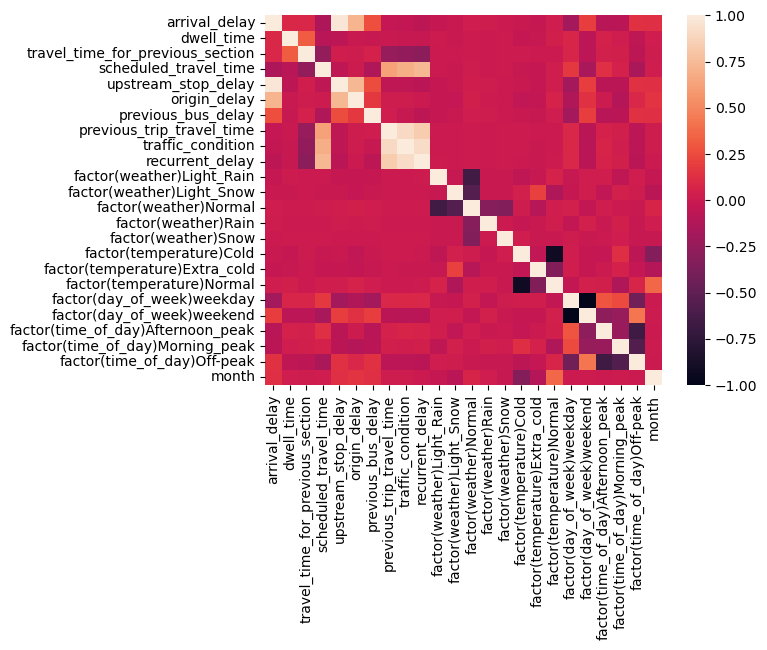

In [15]:
sns.heatmap(df_correlation.corr(), annot=False)

The created correlation matrix and heatmap show that there are several columns correlated with each other. For this research, the most important are the correlations between the arrival_delay and the other columns, because this the target column that we want to predict. We see that the arrival_delay is mainly positively correlated with the upstream_stop_delay (0.975) and with the origin delay (0.716). Furthermore it shows some correlation with the previous bus delay (0.265), the weekday/weekend column (-0.191, 0.191), off-peak factor (0.138), the month (0.129) and the scheduled_travel_time (-0.142).

When looking at the rest of the dataset, we also see strong correlations between the upstream_stop_delay and the origin_delay (0.730). Furthermore we see also correlations between the previous_trip_travel time, the traffic_conditions and the recurrent_delay (0.833-0.918). These last 3 columns are also correlated with the scheduled_travel_time (0.618-0.728).

In the next cell we will consider the distribution of ten busstops in the dataset.

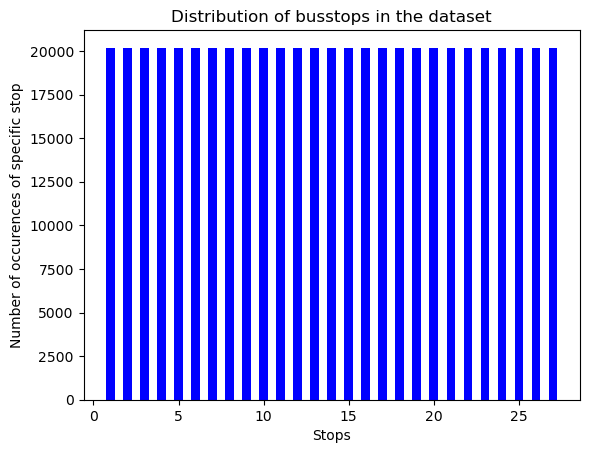

In [16]:
# Distribution of stops:
for i in df["stop_sequence"].unique():
    count = df["stop_sequence"].value_counts()[i]
    plt.bar(i, count, width = 0.5, color="blue")
    plt.xlabel("Stops")
    plt.ylabel("Number of occurences of specific stop")
    plt.title("Distribution of busstops in the dataset")
plt.show()

We see that all stops occur the same number of times. This means that are probably only complete sequences in the dataset.

In the next cell we plot the arrival delay minus the origin delay over the stops. We subtract the origin delay to get a better view on how the arrival delay develops as the buses travel further along the route.

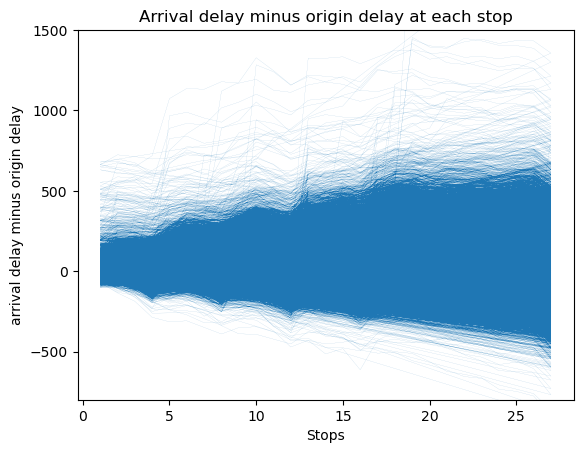

In [17]:
plt.plot(df["stop_sequence"], df["arrival_delay"]-df["origin_delay"], linewidth=0.05)
plt.ylim(-800,1500)
plt.xlabel("Stops")
plt.ylabel("arrival delay minus origin delay")
plt.title("Arrival delay minus origin delay at each stop")
plt.show()

We see no clear upward or downward trend in the data. However, it is clear that the differences between the busses increases along the route (the variance in arrival_delay-origin_delay increases). In addition, we see a slightly wavy pattern in the graph, which means that some stops relatively often cause additional delays, while others stops seems to lead to a decrease in delay. 

In the next cells we will check whether the arrival_delay column is approxiamtely normally distributed. According to Sen, Singh and Chakraborty (2023) this is important for training most machine learning models. First we will look at this graphically with a histogram of the data and a QQ-plot. Lastly we will check the normality numerically with a Kolmogorov-Smirnov test and a Shapiro-Wilk test.  

(array([1.0000e+00, 3.0000e+00, 6.0000e+00, 5.0000e+00, 5.0000e+00,
        4.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 7.0000e+00, 9.0000e+00, 1.7000e+01,
        6.0000e+00, 9.0000e+00, 2.0000e+00, 6.0000e+00, 1.0000e+01,
        8.0000e+00, 2.0000e+00, 5.0000e+00, 1.0000e+01, 1.4000e+01,
        1.0000e+01, 1.2000e+01, 1.3000e+01, 1.4000e+01, 3.0000e+01,
        3.2000e+01, 3.0000e+01, 4.9000e+01, 4.2000e+01, 1.0100e+02,
        3.4300e+02, 1.1300e+03, 3.1780e+03, 1.0593e+04, 3.4299e+04,
        9.2023e+04, 1.0356e+05, 8.5623e+04, 5.9049e+04, 4.3068e+04,
        2.9976e+04, 2.1477e+04, 1.5586e+04, 1.1609e+04, 8.3070e+03,
        6.5310e+03, 4.8500e+03, 3.6730e+03, 2.64

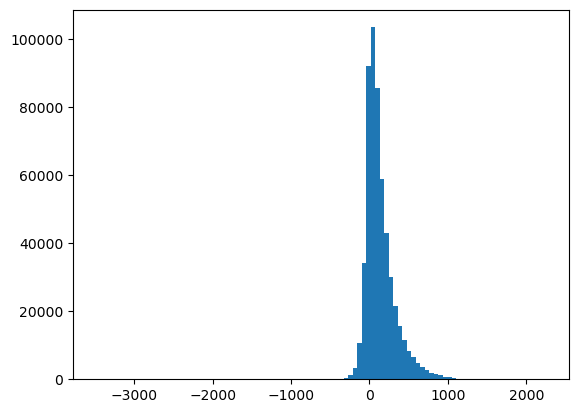

In [18]:
# Distribution of arrival delays (histogram):
plt.hist(df["arrival_delay"], bins=100)

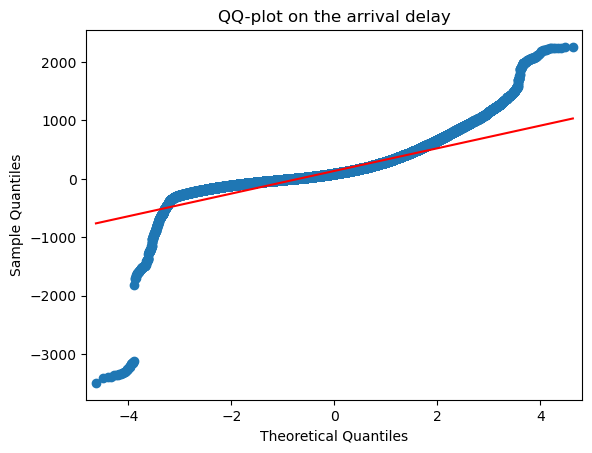

In [19]:
#qq-plot
#Reference: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
qqplot(df["arrival_delay"], line='s')
plt.title("QQ-plot on the arrival delay")
plt.show()

In [20]:
#Kolmogorov-Smirnov test and a Shapiro-Wilk test
#Reference: https://www.statology.org/normality-test-python/
print(kstest(df["arrival_delay"], 'norm'))

print(shapiro(df["arrival_delay"]))

KstestResult(statistic=0.7782036909231179, pvalue=0.0, statistic_location=3, statistic_sign=-1)
ShapiroResult(statistic=0.8616204857826233, pvalue=0.0)


C:\Users\tomko\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The histogram shows that the data is not fully symmetric (a bit skewed to the right) and does not exactly have the form of the Bell-curve. In the QQ-plot we can see that the data defintitely does not follow a normal distribution. This result is confirmed by both numerical tests, because both tests give a p-value below 0.05. There is a significant difference between the arrival delays and the normal distribution.

In the next cells we will look at the difference in distribution in the arrival delay when we group the data by the weather, temperature, day of the week and time of the day respectively.

Text(0.5, 0, 'Weather type')

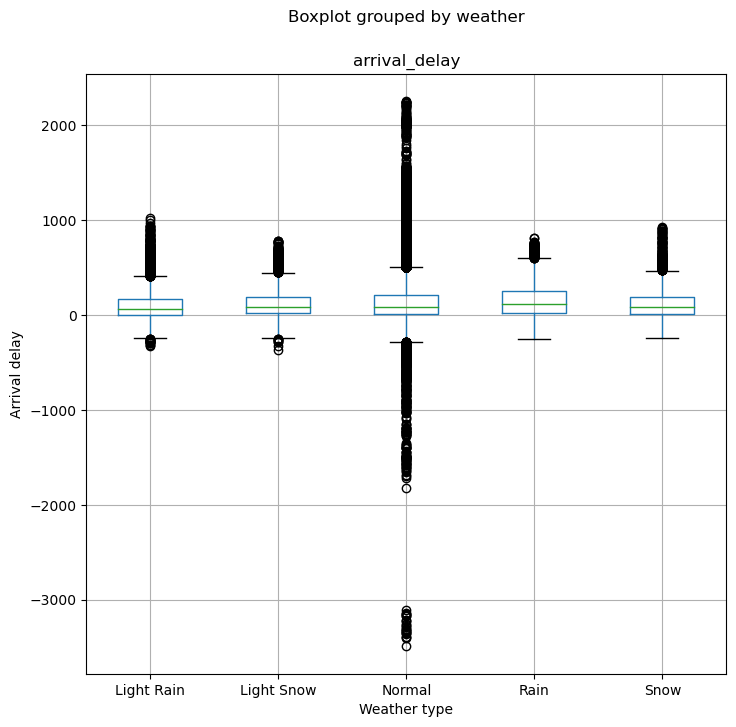

In [21]:
#Arrival delay per weather
boxplots = df.boxplot(column=["arrival_delay"], by=["weather"], figsize=(8,8))
boxplots.set_ylabel("Arrival delay")
boxplots.set_xlabel("Weather type")

Text(0.5, 0, 'Temperature')

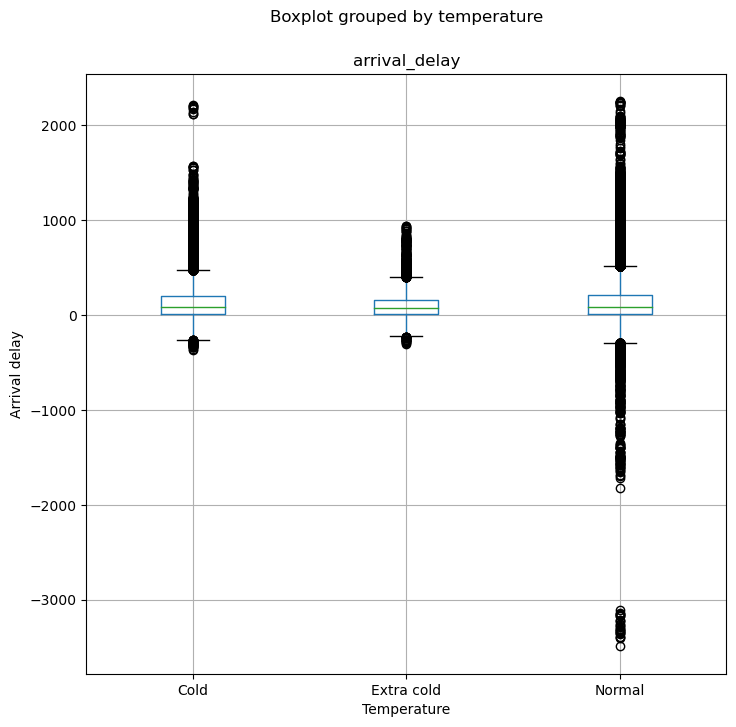

In [22]:
#Arrival delay per temperature type
boxplots = df.boxplot(column=["arrival_delay"], by=["temperature"], figsize=(8,8))
boxplots.set_ylabel("Arrival delay")
boxplots.set_xlabel("Temperature")

Text(0.5, 0, 'Day of the week')

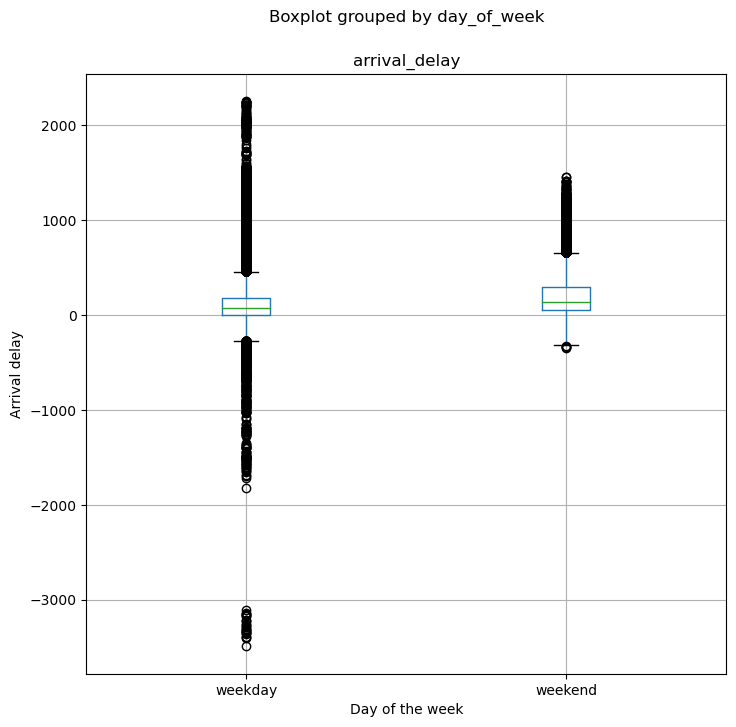

In [23]:
#Arrival delay per day of the week
boxplots = df.boxplot(column=["arrival_delay"], by=["day_of_week"], figsize=(8,8))
boxplots.set_ylabel("Arrival delay")
boxplots.set_xlabel("Day of the week")

Text(0.5, 0, 'Time of day')

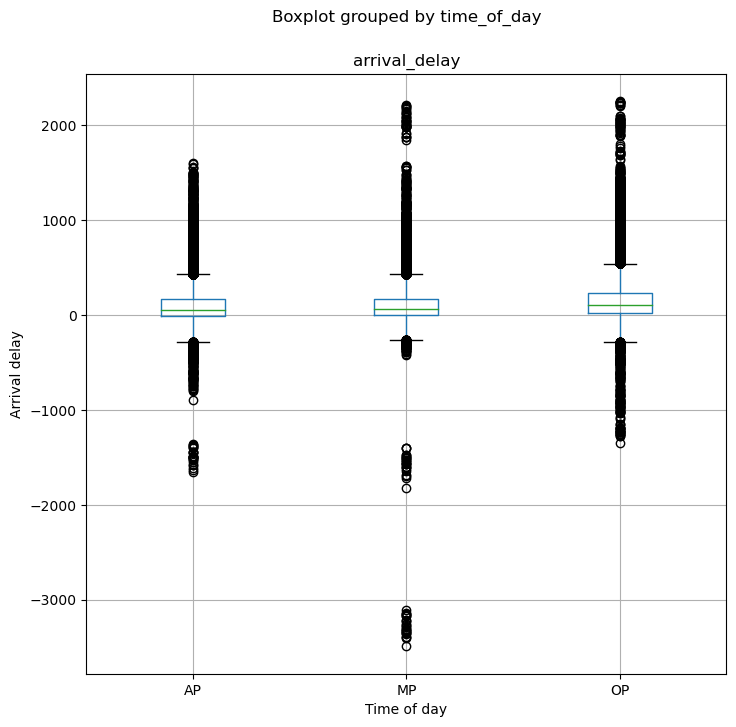

In [24]:
#Arrival delay per time of the day
boxplots = df.boxplot(column=["arrival_delay"], by=["time_of_day"], figsize=(8,8))
boxplots.set_ylabel("Arrival delay")
boxplots.set_xlabel("Time of day")

From the created boxplots, only the day of the week shows a difference in the distribution of the arrival delays between both categories. In the weekend the distribution of the arrival delays is lightly moved upwards. For the other boxplots, we do not see clear differences in the distribution of the arrival delays for the different categories. Furthermore, in each boxplot we see a high number of outliers (the black dots below and above the whiskers).

To have a better look at the bus operation information we create a SNS pairplot with the columns with the highest correlation with the arrival delay. This shows the relations between the columns:

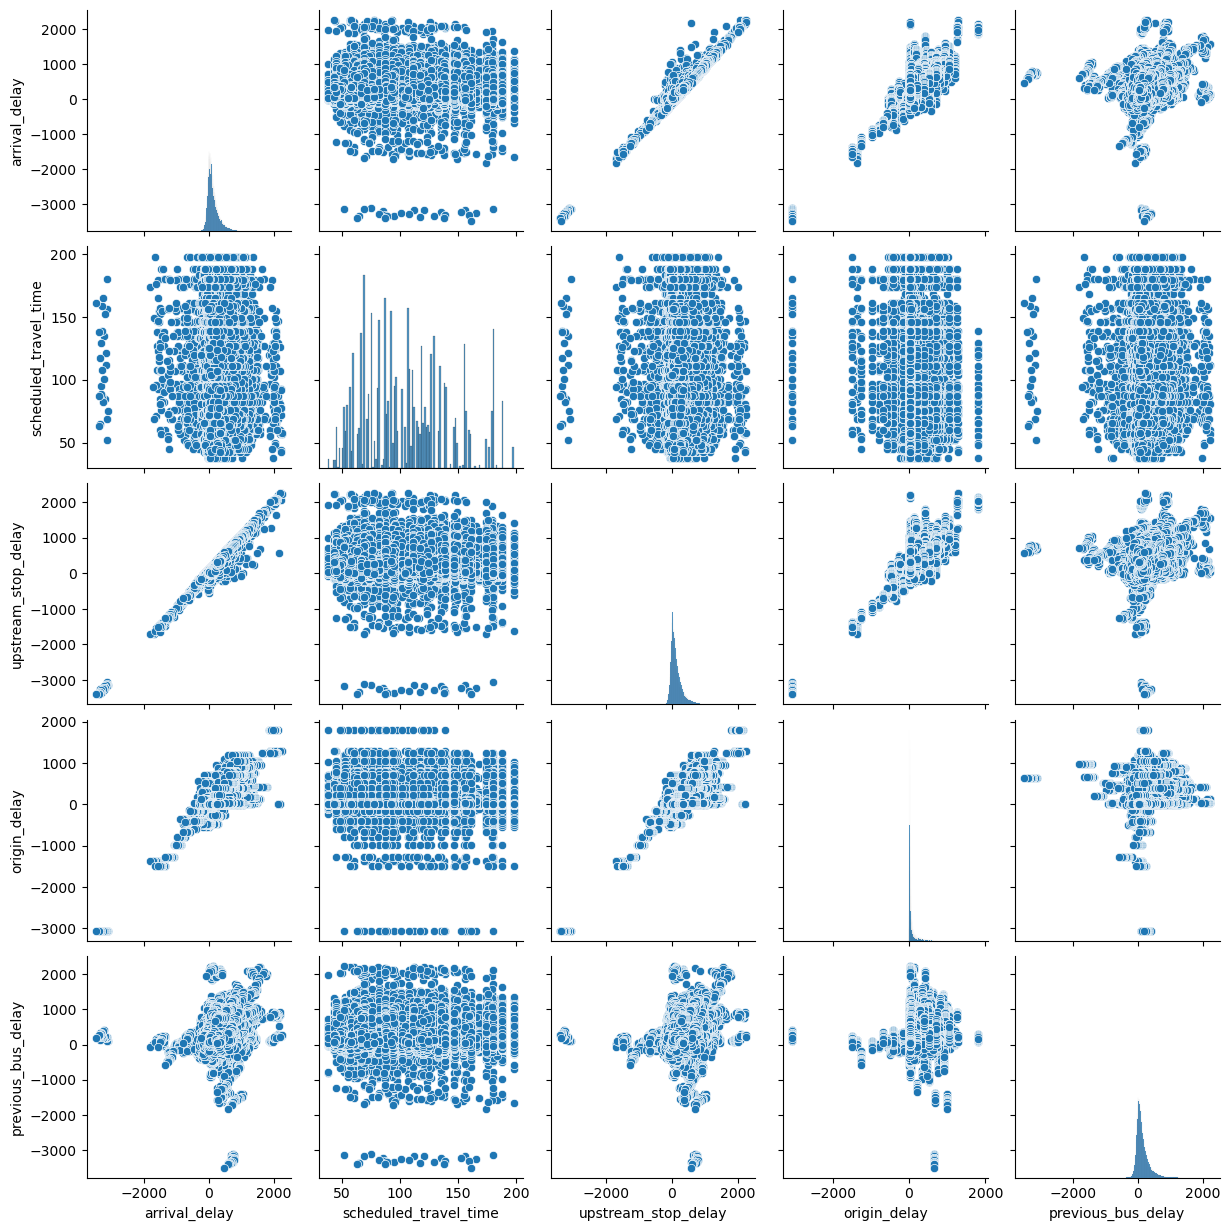

In [25]:
x_pairplot = df[["arrival_delay", "scheduled_travel_time", "upstream_stop_delay", "origin_delay", "previous_bus_delay"]]

sns.pairplot(x_pairplot)

As expected based on the correlation matrix, we see a clear linear relations between the arrival delay and the upstream stop delay. Furthermore, we also see a clear relationship between the arrival delay and the origin delay (although less then the previous). A less clear relationship is vissible between the arrival delay and the previous bus delay. The scheduled travel time does not show a clear relationship with any of the tested other columns. The upstream delay shows approximately the same correlation with the other columns as the arrival delay. This was expected because of the high correlation between both columns. 

In conclusion, mainly the bus operations element columns seem to be important, mainly the upstream stop delay, origin delay and previous delay data. For the object columns the day_of_week (one-hot encoded factor columns) seem to be the most promising. The other object columns do not show a clear correlation with the arrival delay. In the rest of the analysis, we will create a new column with the specific days in it and a new column with the extra delay created between the stop-1 and the stop for which the arrival delay should be predicted for bus j-1. This new column can be interesting, given that the scheduled travel time has less correlation with the arrival delay than we would have expected in advance.

### Step 1.3: Feature engineering

In the previous section we concluded which columns are most useful for training the model. We will try to improve these columns in this section by adding some extra columns based on these, containing new information. First we will extent the information in the day_of_week column by adding a new column with the specific day of the week in it. This is done based on the date column:

In [26]:
df["day"] = df["date"].dt.dayofweek
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Calendar_date                      545103 non-null  int64         
 1   route_id                           545103 non-null  int64         
 2   bus_id                             545103 non-null  int64         
 3   stop_sequence                      545103 non-null  int64         
 4   arrival_delay                      545103 non-null  int64         
 5   dwell_time                         545103 non-null  int64         
 6   travel_time_for_previous_section   545103 non-null  int64         
 7   scheduled_travel_time              545103 non-null  int64         
 8   upstream_stop_delay                545103 non-null  int64         
 9   origin_delay                       545103 non-null  int64         
 10  previous_bus_delay  

In [27]:
df.head(10)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,date,month,day
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
5,20220108,4,41344,6,260,13,105,38,242,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
6,20220108,4,41344,7,278,12,43,79,260,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
7,20220108,4,41344,8,272,8,85,97,278,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
8,20220108,4,41344,9,292,24,83,47,272,100,...,0,1,0,1,0,0,1,2022-01-08,1,5
9,20220108,4,41344,10,351,9,43,85,292,100,...,0,1,0,1,0,0,1,2022-01-08,1,5


The above .head() statement shows that we succeeded in adding a weekday column to the dataset. In this column monday 0 and goes up to 6 for sunday. 

Furthermore we want to add a column with the trip delay on section stop i-1 to stop i for bus j-1. We can than add this to existing delay of bus j to get a prediction for the arrival delay, to be used in the actual prediction by the ML models. 
For this, we first need to have a unique identifier for each trip (from stop 1 to stop 27) and for each trip per day. With this information we can track which bus was previously at that stop and we can find which bus was the first of that day. This last is important, because the first bus of a day is probably not related to the last bus of the previous day. 
Finally we can calculate the extra delay incurred between stop i-1 and the stop i under investigation for bus j-1 and add this to the upstream delay for bus j to get a prediction for the arrival delay of bus j at stop i. This data will be added in a column to the rows of bus j.

In [28]:
# Unique identifier for each route:
route_ID_list = []
counter = 1
memory_stop = 0

for i in df["stop_sequence"]:
    if memory_stop < i:
        route_ID_list.append(counter)
    elif memory_stop > i:
        counter = counter+1
        route_ID_list.append(counter)
    else:
        print("Warning, previous stop equals current stop, route_ID can not be added to dataset")
        print("Current stop: ", i)
        print("Previous stop: ", memory_test)
        print("Expected stop_ID: ", counter)
    memory_stop=i

df["Route_ID"] = route_ID_list

df.head(1000)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,date,month,day,Route_ID
0,20220108,4,41344,1,151,0,0,120,100,100,...,1,0,1,0,0,1,2022-01-08,1,5,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,1,0,1,0,0,1,2022-01-08,1,5,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,1,0,1,0,0,1,2022-01-08,1,5,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,1,0,1,0,0,1,2022-01-08,1,5,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,1,0,1,0,0,1,2022-01-08,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,20220109,4,44418,24,339,12,41,102,350,286,...,0,0,1,0,0,1,2022-01-09,1,6,37
996,20220109,4,44418,25,343,12,79,48,339,286,...,0,0,1,0,0,1,2022-01-09,1,6,37
997,20220109,4,44418,26,340,13,40,66,343,286,...,0,0,1,0,0,1,2022-01-09,1,6,37
998,20220109,4,44418,27,259,0,50,120,340,286,...,0,0,1,0,0,1,2022-01-09,1,6,37


In [29]:
# Unique identifier for each route per day:
# We assume (based on scanning through the CSV file) that the data is ordered over the time axis (first bus first)
route_ID_list_day = []

for j in df["Calendar_date"].unique():
    df_date = df.loc[df["Calendar_date"] == j, ]
    counter_day = 1
    memory_stop_day = 0
    for i in df_date["stop_sequence"]:
        if memory_stop_day < i:
            route_ID_list_day.append(counter_day)
        elif memory_stop_day > i:
            counter_day = counter_day+1
            route_ID_list_day.append(counter_day)
        else:
            print("Warning, previous stop equals current stop, route_ID can not be added to dataset")
            print("Current stop: ", i)
            print("Previous stop: ", memory_stop_day)
            print("Expected stop_ID: ", counter_day)
        memory_stop_day=i
        
df["Route_ID_day"] = route_ID_list_day

df.head(1000)


,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,date,month,day,Route_ID,Route_ID_day
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,1,0,0,1,2022-01-08,1,5,1,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,1,0,0,1,2022-01-08,1,5,1,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,1,0,0,1,2022-01-08,1,5,1,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,1,0,0,1,2022-01-08,1,5,1,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,1,0,0,1,2022-01-08,1,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,20220109,4,44418,24,339,12,41,102,350,286,...,0,1,0,0,1,2022-01-09,1,6,37,15
996,20220109,4,44418,25,343,12,79,48,339,286,...,0,1,0,0,1,2022-01-09,1,6,37,15
997,20220109,4,44418,26,340,13,40,66,343,286,...,0,1,0,0,1,2022-01-09,1,6,37,15
998,20220109,4,44418,27,259,0,50,120,340,286,...,0,1,0,0,1,2022-01-09,1,6,37,15


In [30]:
# Calculate extra delay incurred between stop i-1 and stop i for bus j:
df["extra_delay_bus_j"] = df["arrival_delay"] - df["upstream_stop_delay"]
df.head(54)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,date,month,day,Route_ID,Route_ID_day,extra_delay_bus_j
0,20220108,4,41344,1,151,0,0,120,100,100,...,1,0,0,1,2022-01-08,1,5,1,1,51
1,20220108,4,41344,2,185,24,171,45,151,100,...,1,0,0,1,2022-01-08,1,5,1,1,34
2,20220108,4,41344,3,186,0,55,41,185,100,...,1,0,0,1,2022-01-08,1,5,1,1,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,1,0,0,1,2022-01-08,1,5,1,1,16
4,20220108,4,41344,5,242,21,98,86,202,100,...,1,0,0,1,2022-01-08,1,5,1,1,40
5,20220108,4,41344,6,260,13,105,38,242,100,...,1,0,0,1,2022-01-08,1,5,1,1,18
6,20220108,4,41344,7,278,12,43,79,260,100,...,1,0,0,1,2022-01-08,1,5,1,1,18
7,20220108,4,41344,8,272,8,85,97,278,100,...,1,0,0,1,2022-01-08,1,5,1,1,-6
8,20220108,4,41344,9,292,24,83,47,272,100,...,1,0,0,1,2022-01-08,1,5,1,1,20
9,20220108,4,41344,10,351,9,43,85,292,100,...,1,0,0,1,2022-01-08,1,5,1,1,59


In [38]:
# Replace information from bus j-1 to bus j:
#For the first bus of the day we insert 0, because there is no useful bus j-1 in this case.
extra_delay_list = []
for i in df.index:
    if df.loc[i, "Route_ID_day"] == 1:
        extra_delay_list.append(0)
        #print("delay first bus: ", 0)
    elif df.loc[i, "Route_ID_day"] > 1:
        extra_delay_list.append(df.loc[i-27, "extra_delay_bus_j"])
    else:
        print("Warning: incorrect Route_ID_day value in DataFrame")

df["extra_delay_bus_j-1"] = extra_delay_list
df.head(54)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,date,month,day,Route_ID,Route_ID_day,extra_delay_bus_j,extra_delay_bus_j-1
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,1,2022-01-08,1,5,1,1,51,0
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,1,2022-01-08,1,5,1,1,34,0
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,1,2022-01-08,1,5,1,1,1,0
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,1,2022-01-08,1,5,1,1,16,0
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,1,2022-01-08,1,5,1,1,40,0
5,20220108,4,41344,6,260,13,105,38,242,100,...,0,0,1,2022-01-08,1,5,1,1,18,0
6,20220108,4,41344,7,278,12,43,79,260,100,...,0,0,1,2022-01-08,1,5,1,1,18,0
7,20220108,4,41344,8,272,8,85,97,278,100,...,0,0,1,2022-01-08,1,5,1,1,-6,0
8,20220108,4,41344,9,292,24,83,47,272,100,...,0,0,1,2022-01-08,1,5,1,1,20,0
9,20220108,4,41344,10,351,9,43,85,292,100,...,0,0,1,2022-01-08,1,5,1,1,59,0


In [39]:
# Add the incurred extra delay up with the upstream delay:
df["delay_prediction"] = df["upstream_stop_delay"]+df["extra_delay_bus_j-1"]
df.head(54)


,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,date,month,day,Route_ID,Route_ID_day,extra_delay_bus_j,extra_delay_bus_j-1,delay_prediction
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,1,2022-01-08,1,5,1,1,51,0,100
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,1,2022-01-08,1,5,1,1,34,0,151
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,1,2022-01-08,1,5,1,1,1,0,185
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,1,2022-01-08,1,5,1,1,16,0,186
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,1,2022-01-08,1,5,1,1,40,0,202
5,20220108,4,41344,6,260,13,105,38,242,100,...,0,1,2022-01-08,1,5,1,1,18,0,242
6,20220108,4,41344,7,278,12,43,79,260,100,...,0,1,2022-01-08,1,5,1,1,18,0,260
7,20220108,4,41344,8,272,8,85,97,278,100,...,0,1,2022-01-08,1,5,1,1,-6,0,278
8,20220108,4,41344,9,292,24,83,47,272,100,...,0,1,2022-01-08,1,5,1,1,20,0,272
9,20220108,4,41344,10,351,9,43,85,292,100,...,0,1,2022-01-08,1,5,1,1,59,0,292


The results of the feature engineering stage are presented in the following cells:

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 39 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Calendar_date                      545103 non-null  int64         
 1   route_id                           545103 non-null  int64         
 2   bus_id                             545103 non-null  int64         
 3   stop_sequence                      545103 non-null  int64         
 4   arrival_delay                      545103 non-null  int64         
 5   dwell_time                         545103 non-null  int64         
 6   travel_time_for_previous_section   545103 non-null  int64         
 7   scheduled_travel_time              545103 non-null  int64         
 8   upstream_stop_delay                545103 non-null  int64         
 9   origin_delay                       545103 non-null  int64         
 10  previous_bus_delay  

In [ ]:
df_correlation_features = df.drop(["Calendar_date", "route_id", "bus_id", "stop_sequence", "weather", "temperature", 
                          "day_of_week","time_of_day"], axis=1)
df_correlation_features.corr()

In [ ]:
sns.heatmap(df_correlation_features.corr(), annot=False)

### Step 1.2: Data pre-processing

In [34]:
# Drop the 4 object columns: ["weather", "temperature", "day_of_week", "time_of_day"]
# Delete outliers from the dataset (wrong values) --> e.g. see minimum value of arrival delay column!
# Add column with specific day of the week (1-7)
# Create a seperate dataframe for each busstop in the dataset, with only the data on the previous stops in it?
# Handle imbalanced dataset! --> under or over sampling?
# Handle non-normality of the target feature!
# Data normalization/standardization for all the numerical columns that are not between 0 and 1! --> Standardization handles outliers better, but assumes a gaussian/normal distribution (law of large numbers?)

### Step 1.4: Exploratory data analysis

## Step 2: Train-test split

## Step 3: Training the models

### Step 3.1-3.3: 5-fold cross validation, training the models and finding the best parameter combinations

In [35]:
# Linear regression
# Decision trees
# Random forest
# XGBoost
# Support Vector Machine
# Neural network

### Step 3.4: Train the models on the full training set

## Step 4: Testing the models

### Step 4.1: Make predictions with the models

### Step 4.2: Evaluate model performance

### Step 4.3: Select best model

## Step 5: Final model

### Step 5.1: Train the final model

### Step 5.2: Save the final model

## 6: References

Sen, S., Singh, K.P., Chakraborty, P. (2023). Dealing with imbalanced regression problem for large dataset using scalable artificial neural network. New astronomy, 99. https://doi.org/10.1016/j.newast.2022.101959
